# Day 08. Exercise 02
# Multiclass classification. One-hot encoding. Random forest

## 0. Imports

In [2]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. Preprocessing

1. Read the file [`checker-submits.csv`](https://drive.google.com/file/d/14voc4fNJZiLEFaZyd8nEG-lQt5JjatYw/view?usp=sharing).
2. Create a dataframe `df` with the columns: `uid`, `labname`, `numTrials`, `hour`, `dayofweek` where `hour` is extracted from the `timestamp` as well as the `dayofweek` (`0` is Monday, `6` is Sunday). We will try to predict the day of the week having data about which user made a commit for which lab at which hour and which try it was.
3. Using `OneHotEncoder()` transform your categorical features, delete from the dataframe the initial columns.
4. Use `StandardScaler()` and scale your continuous features.
5. Save the dataframe as `dayofweek.csv`.
6. Before trying out different algorithms, find out the accuracy of the naive algorithms – the one that predicts everything as the most popular class.

In [4]:
df = pd.read_csv('../data/checker_submits.csv')
df.head()

,uid,labname,numTrials,timestamp
0,user_4,project1,1,2020-04-17 05:19:02.744528
1,user_4,project1,2,2020-04-17 05:22:45.549397
2,user_4,project1,3,2020-04-17 05:34:24.422370
3,user_4,project1,4,2020-04-17 05:43:27.773992
4,user_4,project1,5,2020-04-17 05:46:32.275104


In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df = df[['uid', 'labname', 'numTrials', 'hour', 'dayofweek']]

In [6]:
encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df[['uid', 'labname']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['uid', 'labname']))
df = pd.concat([df.drop(['uid', 'labname'], axis=1), encoded_df], axis=1)

In [7]:
scaler = StandardScaler()
df[['numTrials', 'hour']] = scaler.fit_transform(df[['numTrials', 'hour']])
df.head()

,numTrials,hour,dayofweek,uid_user_0,uid_user_1,uid_user_10,uid_user_11,uid_user_12,uid_user_13,uid_user_14,...,labname_lab02,labname_lab03,labname_lab03s,labname_lab05s,labname_laba04,labname_laba04s,labname_laba05,labname_laba06,labname_laba06s,labname_project1
0,-0.788667,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.756764,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.724861,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.692958,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.661055,-2.562352,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
df.to_csv('dayofweek.csv', index=False)


In [9]:
most_common_day = df['dayofweek'].mode()[0]

predictions = [most_common_day] * len(df)

naive_accuracy = accuracy_score(df['dayofweek'], predictions)
naive_accuracy


0.23487544483985764

In [10]:
data = pd.read_csv('dayofweek.csv')

In [11]:
X = data.drop(columns=['dayofweek']) 
y = data['dayofweek']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

## 2. Algorithms

### a. Logreg

1. Train logistic regression, for the baseline model use `random_state=21`, `fit_intercept=False`. 
2. Calculate the accuracy.
3. Write a function that draws the plot (`barh`) taking coefficients of any trained models, names of the features and the number of `top-n` most important features to display.
4. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model.
5. Remember that it is a multiclass classification and `coef_` returns a matrix, to calculate importance for a feature you need to sum all the individual feature importances for all the target values.

In [13]:
logreg = LogisticRegression(random_state=21, fit_intercept=False, max_iter=1000)

In [14]:
logreg.fit(X_train, y_train)

LogisticRegression(fit_intercept=False, max_iter=1000, random_state=21)

In [15]:
y_pred_logreg = logreg.predict(X_test)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_logreg

0.6561264822134387

In [16]:
def plot_feature_importance(coefs, feature_names, top_n=10, title="Feature Importance"):
    importance = np.abs(coefs).sum(axis=0) 
    indices = np.argsort(importance)[-top_n:]  
    top_features = feature_names[indices]
    top_importance = importance[indices]
    
    plt.figure(figsize=(8, 6))
    plt.barh(top_features, top_importance, color='skyblue')
    plt.xlabel("Importance")
    plt.title(title)
    plt.show()

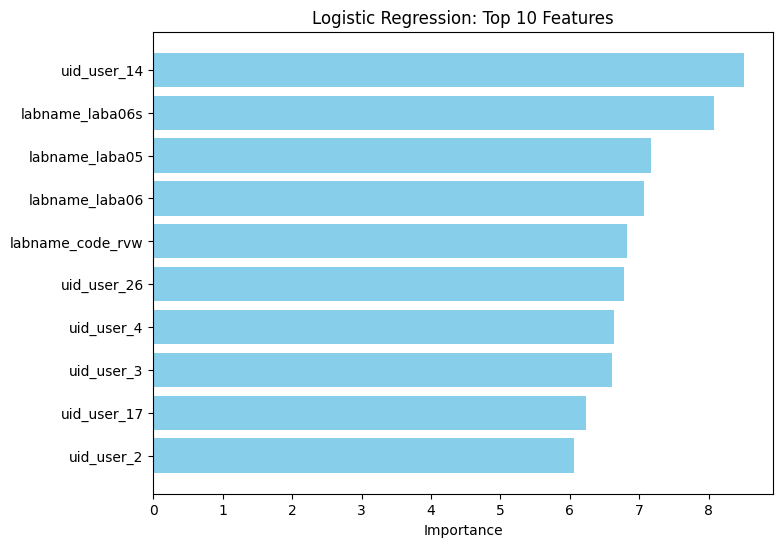

In [17]:
plot_feature_importance(logreg.coef_, X.columns.to_numpy(), top_n=10, title="Logistic Regression: Top 10 Features")

### b. SVC

1. Train a `SVC` model, for the baseline model use parameters `kernel='linear'`, `probability=True`, `random_state=21`. 
2. Try different kernels, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model for the linear kernel *

*By default SVC uses “one vs one” strategy of the classification, thus in `coef_` it returns a matrix. To calculate importance for a feature you need to use [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) over the SVC and sum all the individual feature importances for all the target values.

In [18]:
svc_linear = SVC(kernel='linear', probability=True, random_state=21)
svc_linear_ovr = OneVsRestClassifier(svc_linear)
svc_linear_ovr.fit(X_train, y_train)


OneVsRestClassifier(estimator=SVC(kernel='linear', probability=True,
                                  random_state=21))

In [19]:
y_pred = svc_linear_ovr.predict(X_test)
accuracy_linear = accuracy_score(y_test, y_pred)
accuracy_linear

0.6106719367588933

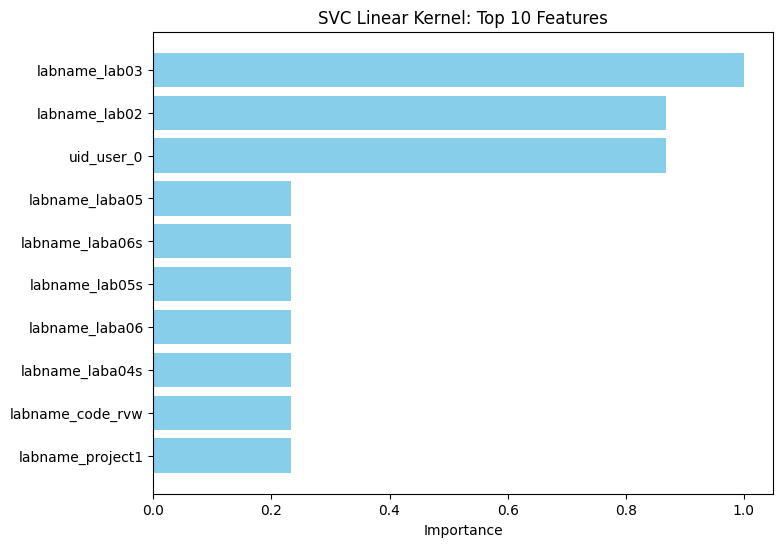

In [20]:
plot_feature_importance(svc_linear_ovr.estimators_[0].coef_, X.columns.to_numpy(), top_n=10, title="SVC Linear Kernel: Top 10 Features")

In [21]:
kernels = ['poly', 'rbf', 'sigmoid']
for kernel in kernels:
    svc_model = SVC(kernel=kernel, probability=True, random_state=21)
    svc_model.fit(X_train, y_train)

    y_pred = svc_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy ({kernel.capitalize()} Kernel): {accuracy:.4f}")

Accuracy (Poly Kernel): 0.8320
Accuracy (Rbf Kernel): 0.8261
Accuracy (Sigmoid Kernel): 0.4308


### c. Decision tree

1. Train a `DecisionTreeClassifier` using for the baseline model `max_depth=4`, `random_state=21`. 
2. Try different values of `max_depth`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [22]:
baseline_model = DecisionTreeClassifier(max_depth=4, random_state=21)
baseline_model.fit(X_train, y_train)

y_pred_baseline = baseline_model.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_accuracy 

0.5395256916996047

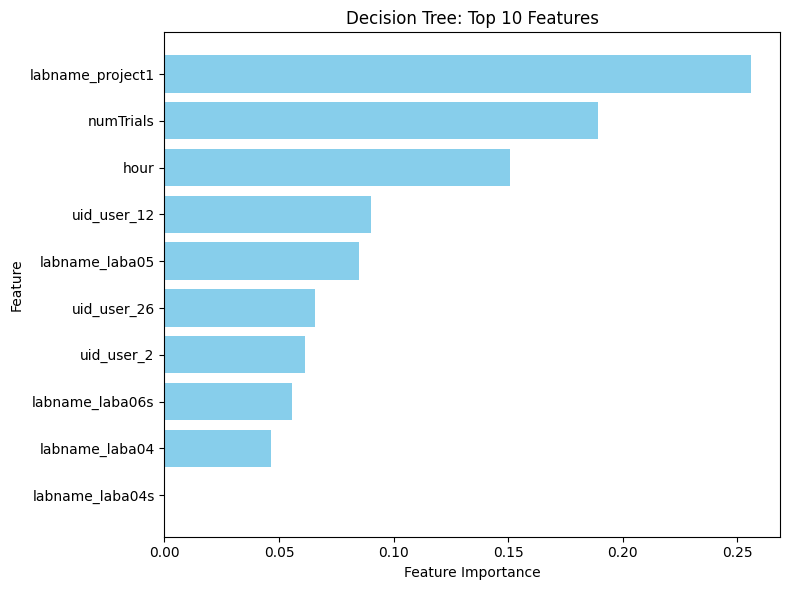

In [23]:

def plot_feature_importance(coefs, feature_names, top_n=10, title="Feature Importance"):
    importance = np.array(coefs)
    feature_names = np.array(feature_names)
    
    indices = np.argsort(importance)[-top_n:]  
    top_features = feature_names[indices]
    top_importance = importance[indices]
    
    plt.figure(figsize=(8, 6))
    plt.barh(top_features, top_importance, color='skyblue')
    plt.title(title)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


    
plot_feature_importance(
    baseline_model.feature_importances_,
    X.columns.to_numpy(),
    top_n=10,
    title="Decision Tree: Top 10 Features"
)

In [24]:
depths = [2, 4, 6, 8, 10]

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth, random_state=21)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for max_depth={depth}: {accuracy:.4f}")

Accuracy for max_depth=2: 0.4209
Accuracy for max_depth=4: 0.5395
Accuracy for max_depth=6: 0.6186
Accuracy for max_depth=8: 0.6996
Accuracy for max_depth=10: 0.7372


### d. Random forest

In real life forest is a set of trees. The same thing is with machine learning. Random forest is a set of individual decision trees (check the documentation for more details).

1. Train a `RandomForestClassifier` using for the baseline model parameters `n_estimators=100`, `max_depth = 25`, `random_state=21`. 
2. Try different values of `max_depth` and `n_estimators`, calculate the accuracies.
3. Draw a plot (`barh`) for the baseline model with top-10 most important features (absolute value) for the trained model using the written function.

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=25, random_state=21)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Baseline Random Forest Accuracy (n_estimators=100, max_depth=25): {rf_accuracy:.4f}")

Baseline Random Forest Accuracy (n_estimators=100, max_depth=25): 0.9190


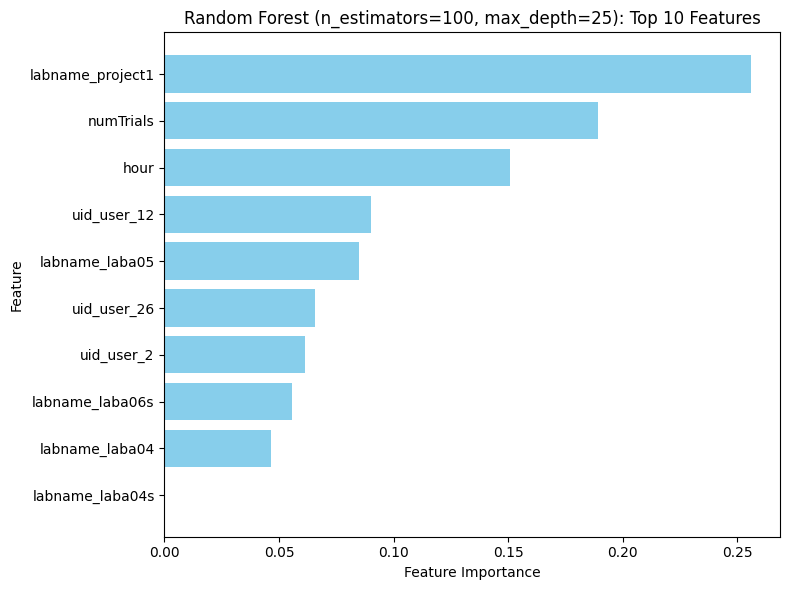

In [26]:
plot_feature_importance(
    baseline_model.feature_importances_,
    X.columns.to_numpy(),
    top_n=10,
    title="Random Forest (n_estimators=100, max_depth=25): Top 10 Features"
)

In [29]:
depths = [10, 20, 25, 30]
estimators = [50, 100, 150]

print("\nTesting different hyperparameters for Random Forest:")
for depth in depths:
    for n_estimators in estimators:
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=21)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"max_depth={depth}, n_estimators={n_estimators}: accuracy={accuracy:.4f}")


Testing different hyperparameters for Random Forest:
max_depth=10, n_estimators=50: accuracy=0.8281
max_depth=10, n_estimators=100: accuracy=0.8241
max_depth=10, n_estimators=150: accuracy=0.8202
max_depth=20, n_estimators=50: accuracy=0.9111
max_depth=20, n_estimators=100: accuracy=0.9150
max_depth=20, n_estimators=150: accuracy=0.9170
max_depth=25, n_estimators=50: accuracy=0.9190
max_depth=25, n_estimators=100: accuracy=0.9190
max_depth=25, n_estimators=150: accuracy=0.9190
max_depth=30, n_estimators=50: accuracy=0.9209
max_depth=30, n_estimators=100: accuracy=0.9190
max_depth=30, n_estimators=150: accuracy=0.9209
